# Install ONNX

In [1]:
# Install core ONNX export requirements
!pip install --upgrade onnx onnxscript

# Install ONNX Runtime for inference
!pip install onnxruntime

# If you have a GPU and want acceleration
!pip install onnxruntime-gpu

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.2.dev0-py3.12.egg is deprecated. pip 25.1 will enforc

# Convert Model

In [2]:
import torch
import argparse
from timm import create_model

def convert_densenet_to_onnx(model_path, output_path):
    # Create a DenseNet121 model with 1 input channel instead of 3
    model = models.densenet121()
    
    # Modify the first convolution layer to accept 1 channel instead of 3
    # Save the original weights
    original_conv = model.features.conv0
    
    # Create a new conv layer with 1 input channel but same output channels
    model.features.conv0 = torch.nn.Conv2d(
        1, 
        original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=(original_conv.bias is not None)
    )
    
    # Load the weights from the .pth file
    state_dict = torch.load(model_path)
    
    # Handle different model save formats
    if isinstance(state_dict, dict) and "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    
    # Load the state dict with strict=False to allow for mismatches
    model.load_state_dict(state_dict, strict=False)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Create dummy input with 1 channel instead of 3
    dummy_input = torch.randn(1, 1, 224, 224)
    
    # Export the model to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        export_params=True,
        opset_version=10,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model has been converted to ONNX and saved at: {output_path}")

def convert_resnet50d_to_onnx(model_path, output_path):
    # Load the state dict to check its structure
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    
    # Check if the state dict has a nested structure
    if isinstance(state_dict, dict) and "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    
    # Option 1: Create model with correct number of classes (6)
    model = create_model('resnet50d', pretrained=False, num_classes=6)
    
    # Option 2: Alternatively, remove the mismatched layers before loading
    # model = create_model('resnet50d', pretrained=False)
    # if 'fc.weight' in state_dict:
    #     state_dict.pop('fc.weight')
    # if 'fc.bias' in state_dict:
    #     state_dict.pop('fc.bias')
    
    # Load state dict
    try:
        model.load_state_dict(state_dict, strict=False)
    except Exception as e:
        print(f"Error loading state dictionary: {e}")
        print("Attempting to modify state dict to match model structure...")
        
        # Create a new filtered state dict
        filtered_state_dict = {k: v for k, v in state_dict.items() 
                              if k not in ['fc.weight', 'fc.bias']}
        model.load_state_dict(filtered_state_dict, strict=False)
    
    # Set model to evaluation mode
    model.eval()
    
    # Create dummy input
    dummy_input = torch.randn(1, 3, 224, 224)
    
    # Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        export_params=True,
        opset_version=12,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model has been converted to ONNX and saved at: {output_path}")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
convert_resnet50d_to_onnx("./model/monoai.pth",    	"./model/monoai.onnx")
convert_resnet50d_to_onnx("./model/timm_base.pth", 	"./model/timm_base.onnx")
convert_resnet50d_to_onnx("./model/timm_optim.pth", "./model/timm_optim.onnx")

Model has been converted to ONNX and saved at: ./model/monoai.onnx
Model has been converted to ONNX and saved at: ./model/timm_base.onnx
Model has been converted to ONNX and saved at: ./model/timm_optim.onnx


# Test the model

In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the preprocessing transforms
# These are standard transforms for ResNet models
transform = transforms.Compose([
	transforms.Resize(256),
	transforms.CenterCrop(224),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to test folder
test_dir = "./data/test"

# Create dataset from test folder
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loader
test_loader = DataLoader(
	test_dataset,
	batch_size=32,
	shuffle=False,
	num_workers=4
)

print(f"Test dataset contains {len(test_dataset)} images")
print(f"Class mapping: {test_dataset.class_to_idx}")

Test dataset contains 5895 images
Class mapping: {'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


In [6]:
import numpy as np
import onnxruntime as ort
import time
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def run_onnx_model(model_path, test_loader, device='cpu'):
    print(f"\nRunning model: {model_path} on {device}")
    
    # Set up ONNX Runtime session based on device
    if device == 'cpu':
        session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
    else:
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        session = ort.InferenceSession(model_path, providers=providers)
    
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    # Collect predictions and ground truth
    all_preds = []
    all_labels = []
    total_time = 0
    total_samples = 0
    
    # Run inference on test data
    for inputs, labels in test_loader:
        batch_size = inputs.shape[0]
        total_samples += batch_size
        
        # Convert to numpy for ONNX Runtime
        inputs_np = inputs.numpy()
        
        # Time the inference
        start_time = time.time()
        outputs = session.run([output_name], {input_name: inputs_np})[0]
        end_time = time.time()
        
        inference_time = end_time - start_time
        total_time += inference_time
        
        # Get predictions
        preds = np.argmax(outputs, axis=1)
        
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
    
    # Calculate accuracy and other metrics
    accuracy = accuracy_score(all_labels, all_preds)
    avg_time_per_batch = total_time / len(test_loader)
    avg_time_per_sample = total_time / total_samples
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Total inference time: {total_time:.4f} seconds")
    print(f"Average time per batch: {avg_time_per_batch:.4f} seconds")
    print(f"Average time per sample: {avg_time_per_sample*1000:.4f} ms")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(test_dataset.class_to_idx.keys())))
    
    return {
        'accuracy': accuracy,
        'total_time': total_time,
        'avg_time_per_batch': avg_time_per_batch,
        'avg_time_per_sample': avg_time_per_sample
    }

In [11]:
# List of models to evaluate
models = [
    "./model/monoai.onnx",
    "./model/timm_base.onnx",
    "./model/timm_optim.onnx"
]

# Check if CUDA is available
cuda_available = 'CUDAExecutionProvider' in ort.get_available_providers()
print(f"Available ONNX Runtime providers: {ort.get_available_providers()}")
print(f"CUDA available: {cuda_available}")


# Run all models on GPU
results = {}
if cuda_available:
    for model_path in models:
        model_name = os.path.basename(model_path)
        results[model_name] = run_onnx_model(model_path, test_loader, device='cuda' if cuda_available else 'cpu')

Available ONNX Runtime providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
CUDA available: True

Running model: ./model/monoai.onnx on cuda
Accuracy: 0.0278
Total inference time: 3.3734 seconds
Average time per batch: 0.0182 seconds
Average time per sample: 0.5722 ms

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       0.00      0.00      0.00       986
   BreastMRI       0.00      0.00      0.00       895
         CXR       0.03      0.15      0.05      1030
     ChestCT       0.00      0.00      0.00       972
        Hand       0.77      0.01      0.02      1004
      HeadCT       0.00      0.00      0.00      1008

    accuracy                           0.03      5895
   macro avg       0.13      0.03      0.01      5895
weighted avg       0.14      0.03      0.01      5895


Running model: ./model/timm_base.onnx on cuda
Accuracy: 0.0278
Total inference time: 3.3734 seconds
Average time per batch: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.3411
Total inference time: 3.2559 seconds
Average time per batch: 0.0176 seconds
Average time per sample: 0.5523 ms

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       1.00      0.92      0.96       986
   BreastMRI       1.00      0.35      0.52       895
         CXR       0.00      0.00      0.00      1030
     ChestCT       0.00      0.00      0.00       972
        Hand       0.38      0.60      0.47      1004
      HeadCT       0.21      0.18      0.19      1008

    accuracy                           0.34      5895
   macro avg       0.43      0.34      0.36      5895
weighted avg       0.42      0.34      0.35      5895


Running model: ./model/timm_optim.onnx on cuda
Accuracy: 0.6601
Total inference time: 3.2586 seconds
Average time per batch: 0.0176 seconds
Average time per sample: 0.5528 ms

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       0.99      1.00      1.00       

/tmp/ipykernel_40549/3481562586.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40549/3481562586.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


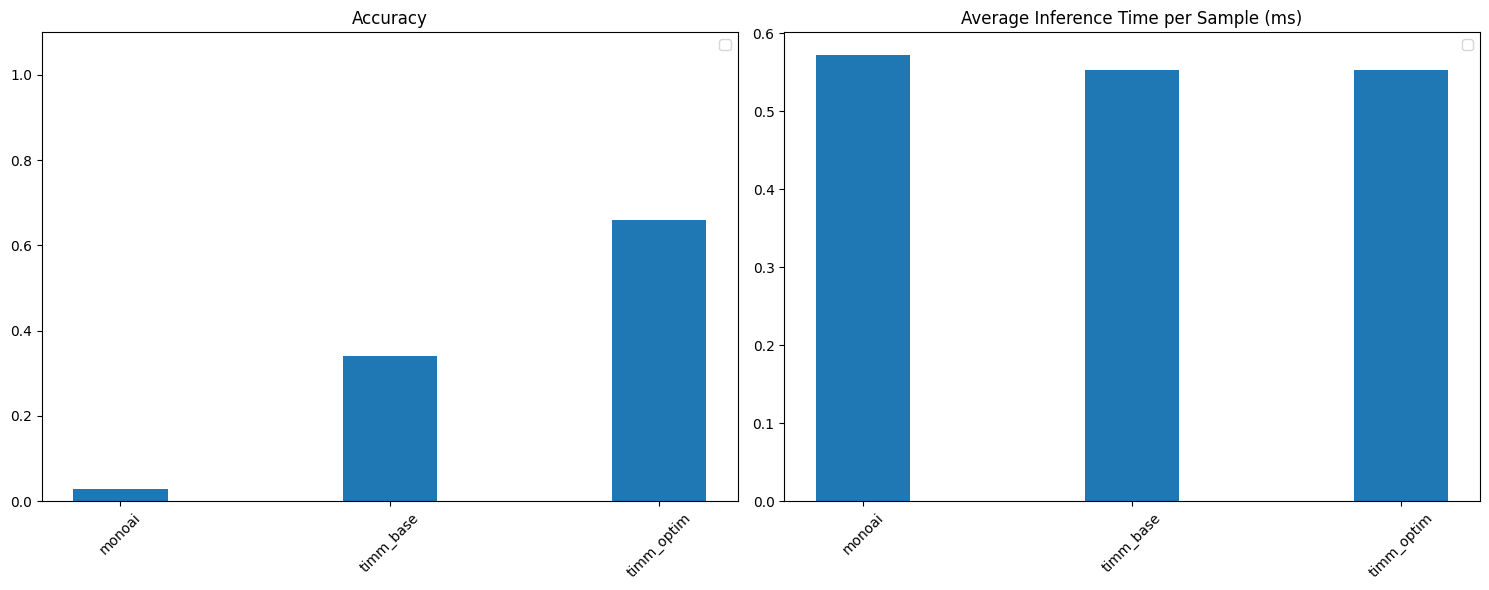

In [12]:
# Plot results
def plot_comparison(results=None):
    models = list(results.keys())
    metrics = ['accuracy', 'avg_time_per_sample']
    titles = ['Accuracy', 'Average Inference Time per Sample (ms)']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        values = [results[model][metric] for model in models]
        
        # Convert time to milliseconds for better readability
        if metric == 'avg_time_per_sample':
            values = [v * 1000 for v in values]  # Convert to ms
        
        x = np.arange(len(models))
        width = 0.35
        
        axes[i].bar(x, values, width)
        
        axes[i].set_title(title)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels([m.split('.')[0] for m in models], rotation=45)
        
        if metric == 'accuracy':
            axes[i].set_ylim(0, 1.1)
        
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_comparison(results)

In [15]:
# Create a table comparing all results
import pandas as pd

def create_comparison_table(results):
    data = []
    for model_name in results.keys():
        model_base = model_name.split('.')[0]
        row = {
            'Model': model_base,
			'Accuracy': f"{results[model_name]['accuracy']:.4f}",
			'Inference Time (ms)': f"{results[model_name]['avg_time_per_sample']*1000:.2f}"
		}
            
        data.append(row)
    
    df = pd.DataFrame(data)
    return df

comparison_table = create_comparison_table(results)
comparison_table

,Model,Accuracy,Inference Time (ms)
0,monoai,0.0278,0.57
1,timm_base,0.3411,0.55
2,timm_optim,0.6601,0.55
